### 使用numpy实现简单的RNN前向传递

#### RNN伪代码

In [ ]:
state_t = 0  # t时刻的状态
for input_t in input_sequence:  # 对序列元素遍历
    output_t = f(input_t, state_t)
    state_t = output_t  # 前一次的输出变成下一次迭代的状态

#### 更详细的RNN伪代码

In [ ]:
state_t = 0  # t时刻的状态
for input_t in input_sequence:  # 对序列元素遍历
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t  # 前一次的输出变成下一次迭代的状态

#### 简单RNN的numpy实现

In [7]:
import numpy as np

timesteps = 100  # 时间步
input_features = 32  # 输入特征空间的纬度
output_features = 64  # 输出特征空间纬度

inputs = np.random.random((timesteps, input_features))  # 输入数据：随机噪声，仅作为示例
state_t = np.zeros((output_features,))  # 输出数据，全零向量

# 创建随机的权重矩阵
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t

final_output_sequence = np.stack(successive_outputs, axis=0)
print(final_output_sequence.shape)

(100, 64)


### keras中的循环层
以上的numpy对应一个实际的keras层，即SimpleRNN层

In [ ]:
from keras.layers import SimpleRNN

与numpy的RNN实现略微不同，SimpleRNN可以处理序列批量，而不是只能处理单个序列。因此，它接收的形状为(batch_size, timesteps, input_features)的输入，而不是(timesteps, input_features)。

与Keras中的所有循环层一样，SimpleRNN可以在两种不同的模式下运行：一种是返回每个时间步连续输出的完整序列，即形状为(batch_size,timesteps,output_features)的三维张量；另一种是只返回每个输入序列的最终输出，即形状为(batch_size,output_features)的二维张量。这两种模式由return_sequences这个构造函数参数来控制。我们来看一个使用SimpleRNN的例子，它只返回最后一个时间步的输出。 

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


下面返回完整的状态序列

In [10]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


### 搞一波IMDB的电影评论分类

#### 准备IMDB数据

In [11]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # 作为特征的单词个数
maxlen = 500  # 在这么多单词之后截断文本
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

print(len(input_train), 'train_sequences')
print(len(input_test), 'test_sequences')
print('Pad sequence (sample x time)')

input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train_sequences
25000 test_sequences
Pad sequence (sample x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


#### 用Embedding和SimpleRNN层来训练模型

In [12]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

W0905 20:58:26.705943 140736197415872 deprecation_wrapper.py:119] From /Users/schp/miniconda2/envs/keras2.0.8/lib/python3.6/site-packages/keras/optimizers.py:711: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0905 20:58:26.730252 140736197415872 deprecation_wrapper.py:119] From /Users/schp/miniconda2/envs/keras2.0.8/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2819: The name tf.log is deprecated. Please use tf.math.log instead.

W0905 20:58:26.738861 140736197415872 deprecation.py:323] From /Users/schp/miniconda2/envs/keras2.0.8/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0905 20:58:27.074650 140736197415872 deprecation.py:506] From /Users/schp/miniconda2/envs/keras2.0.8/lib/

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 18s - loss: 0.6617 - acc: 0.6002 - val_loss: 0.5787 - val_acc: 0.7582
Epoch 2/10
20000/20000 [==============================] - 17s - loss: 0.4235 - acc: 0.8253 - val_loss: 0.4043 - val_acc: 0.8212
Epoch 3/10
20000/20000 [==============================] - 17s - loss: 0.2841 - acc: 0.8880 - val_loss: 0.4072 - val_acc: 0.8356
Epoch 4/10
20000/20000 [==============================] - 18s - loss: 0.1992 - acc: 0.9263 - val_loss: 0.4020 - val_acc: 0.8232
Epoch 5/10
20000/20000 [==============================] - 19s - loss: 0.1389 - acc: 0.9497 - val_loss: 0.4552 - val_acc: 0.8456
Epoch 6/10
20000/20000 [==============================] - 18s - loss: 0.0913 - acc: 0.9683 - val_loss: 0.4790 - val_acc: 0.8336
Epoch 7/10
20000/20000 [==============================] - 18s - loss: 0.0621 - acc: 0.9799 - val_loss: 0.6167 - val_acc: 0.8026
Epoch 8/10
20000/20000 [==============================]

#### 绘制结果

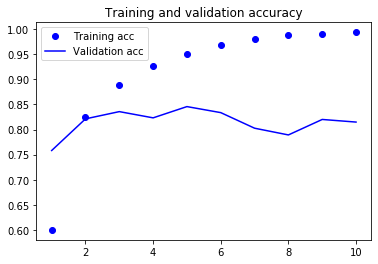

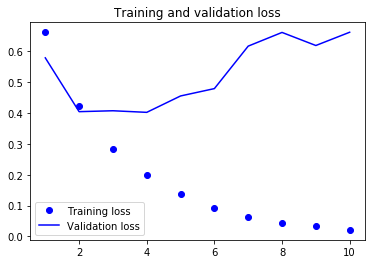

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()